In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# ******************************************************************
def dvdt(x):
    '''
    Function to calculate the acceleration
    
    Inputs:
    x : 2 element array for coordinates in x and y

    Output:
    acceleration
    '''
    
    grav_g = 39.47 # gravitational constant in AU*yr^2/Msun
    m_sun = 1 # in AU
    
    return -grav_g*m_sun*x[0]/(x[0]**2+x[1]**2)**(3/2)
# ******************************************************************

# ******************************************************************
def mod_midpoint(delta_t,n_time,x0,v0):
    '''
    Function to implement the modified midpoint method
    
    Inputs:
    delta_t : Size of the timestep (years)
    n_time : Number of timesteps
    x0 : Numpy array with initial position in x and y
    v0 : Numpy array with initial velocity in x and y
    
    Outputs:
    x_end : Numpy array with final position in x and y 
    v_end : Numpy array with final velocity in x and y
    '''

    # Make sure x0 and v0 are numpy arrays
    if isinstance(x0,list): x0=np.array(x0)
    if isinstance(v0,list): v0=np.array(v0)

    # Initial Euler half step for position and velocity
    x_mid=x0+0.5*v0*delta_t
    v_mid=v0+0.5*np.array([dvdt(x0),dvdt(np.flip(x0))])*delta_t
    
    x_end=np.copy(x0)# Careful with shallow copies!
    for t in range(n_time):
        
        # Position at t + \Delta t
        x_end+=v_mid*delta_t
        
        # Velocity a t + \Delta t
        k1=np.array([dvdt(x_end),dvdt(np.flip(x_end))])*delta_t
        v_end=v_mid+0.5*k1
        
        # To avoid going beyond the interval
        if t < n_time-1:
            
            # Velocity at t + (3/2) \Delta t
            v_mid+=k1
            
            # Position at t + (3/2) \Delta t
            x_mid+=v_end*delta_t 
            
    # Now we average our resuts for position/velocity according to the MMM
    x_end=0.5*(x_end+x_mid+0.5*delta_t*v_end)
    v_end=0.5*(v_end+v_mid+0.5*np.array([dvdt(x_end),dvdt(np.flip(x_end))])*delta_t)
    
    return x_end, v_end
# ******************************************************************

# ******************************************************************
def richardson_extrap(Rij,n,m):
    '''
    Function to implement Richardson extrapolation.
    
    Inputs:
    Rij : Nested list storing predicted values at different n,m
    n,m : Indices of the Richardson extrapolation
    
    Outputs:
    Rij : Updated nested list with new element 
    error : Error for the given n,m
    '''
    
    try:
        error = (Rij[n-1][m-1]-Rij[n-2][m-1])/( (n/(n-1))**(2*m) - 1 )              
        Rij[n-1].append(Rij[n-1][m-1]+error)
    except IndexError:
        print('Index out of range for Richardson Extrapolation.')

    return Rij, error
# ******************************************************************

# ******************************************************************
def bs_orbit(x0,v0,t_final,des_error,delta_t0=1.0/36.50,n_RI = 10):
    ''' 
    Function to calculate orbital trajectory with the 2nd order Runge-Kutta method
    
    Input:
    x0 : 2 element array for initial coordinates in x and y in AU
    v0 : 2 element array for initial velocity in x and y in AU/year
    t_final : final time of the simulation in years
    des_error : desired error
    delta_t0 : initial timestep to start the adaptive algorithm
    n_RI : Maximum number of Richardson extrapolation steps to do
    
    Output:
    pos : array of coordinates at each timestep in AU
    vel : array of velocities at each timestep in AU/year   
    '''
        
    # Set up initial conditions in lists
    pos=[x0]
    vel=[v0]
    delta_t=[delta_t0]
    time=[0.0]
    Rijs=[]

    # Loop over timesteps
    while time[-1] < t_final:
        
        # Initialize everything for this timestep
        n = 1
        Rij_pos=[] # To hold Richardson extrapolation values
        Rij_vel=[] # To hold Richardson extrapolation values
        x0=pos[-1]
        v0=vel[-1]

        # Make sure we make it into the loop and complete one iteration
        error = 2.0*des_error
        
        # Just trying to get below our desired error
        while error > des_error:
            
            # Test if we have done too many steps
            if n > n_RI:
                raise Exception('Could not converge to within '+str(des_error)+' in '+str(n_RI)+' RI steps. Increase n_RI.')
            
            # Step of MMM with delta_t some fraction of delta_t0
            delta_t_bs = delta_t0/n
            x_end, v_end=mod_midpoint(delta_t_bs,n,x0,v0)            
            Rij_pos.append([x_end])
            Rij_vel.append([v_end])

            # Loop through the m in the Richardson Extrapolation scheme
            for m in range(1,n):
                Rij_pos,error_pos=richardson_extrap(Rij_pos,n,m)
                Rij_vel,error_vel=richardson_extrap(Rij_vel,n,m)
                
                # We will just test error in norm of positions
                error=np.linalg.norm(error_pos)
            
            # Next n step
            n+=1
        
        # Store the converged values
        pos.append(Rij_pos[-1][-1])
        vel.append(Rij_vel[-1][-1])
        
        Rijs.append([Rij_pos,Rij_vel])
        
        delta_t.append(delta_t_bs)
        time.append(time[-1]+delta_t0)
    
    return np.stack(pos),np.stack(vel),np.array(delta_t),np.array(time),Rijs
# ******************************************************************

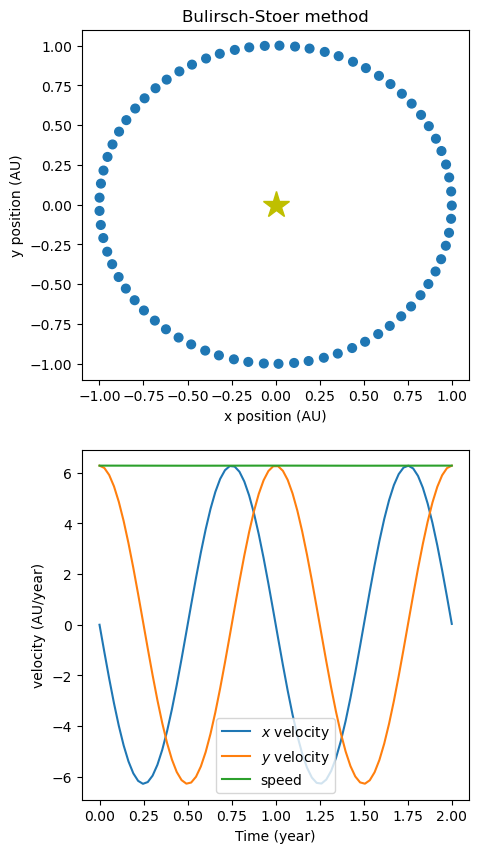

In [8]:
x0=[1.0,0.0]
v0=[0.0,6.283185]
des_error = 1.0e-10
t_final = 2.0

# Run the adaptive rk4 method
pos_bs,vel_bs,delta_t_bs,time_bs,Rijs_bs=bs_orbit(x0,v0,t_final,des_error)

# Plot the trajectory!
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(5,10))

ax1.scatter(pos_bs[1:,0],pos_bs[1:,1],s=10000*delta_t_bs[1:])
ax1.plot(0,0,'y*',markersize=20)

ax2.plot(time_bs,vel_bs[:,0], label='$x$ velocity')
ax2.plot(time_bs,vel_bs[:,1], label='$y$ velocity')
ax2.plot(time_bs,np.sqrt(vel_bs[:,0]**2+vel_bs[:,1]**2), label='speed')

ax1.set_ylabel('y position (AU)')
ax1.set_xlabel('x position (AU)')
ax1.set_title('Bulirsch-Stoer method')

ax2.set_ylabel('velocity (AU/year)')
ax2.set_xlabel('Time (year)')
ax2.legend()

plt.savefig('bs_circular.pdf',bbox_inches='tight')

plt.show()

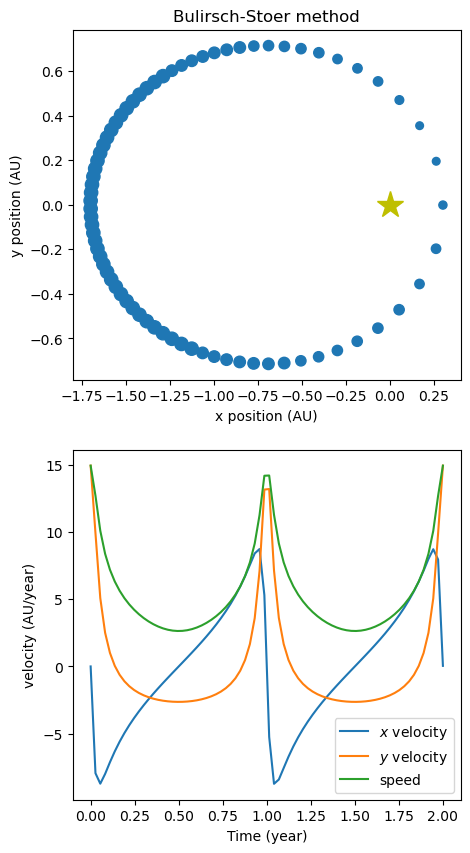

In [9]:
# Conditions for the simulation
x0=[0.3,0.0]
v0=[0.0,14.955378]
des_error = 1.0e-7
t_final = 2.0

# Run the Bulirsch-Stoer method
pos_bs,vel_bs,delta_t_bs,time_bs,Rijs_bs=bs_orbit(x0,v0,t_final,des_error)

# Plot the trajectory!
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(5,10))

ax1.scatter(pos_bs[1:,0],pos_bs[1:,1],s=10000*delta_t_bs[1:])
ax1.plot(0,0,'y*',markersize=20)

ax2.plot(time_bs,vel_bs[:,0], label='$x$ velocity')
ax2.plot(time_bs,vel_bs[:,1], label='$y$ velocity')
ax2.plot(time_bs,np.sqrt(vel_bs[:,0]**2+vel_bs[:,1]**2), label='speed')

ax1.set_ylabel('y position (AU)')
ax1.set_xlabel('x position (AU)')
ax1.set_title('Bulirsch-Stoer method')

ax2.set_ylabel('velocity (AU/year)')
ax2.set_xlabel('Time (year)')
ax2.legend()

plt.savefig('bs_elliptical.pdf',bbox_inches='tight')

plt.show()

In [10]:
# Let's print some Rij's. This is for the third timestep:
print('Timestep : 2, x position')
for m in Rijs_bs[2][0]:
    for n in m:
        print(np.round(n[0],10),end=' ')
    print('')

print()
print('Timestep : 2, x velocity')
for m in Rijs_bs[2][1]:
    for n in m:
        print(np.round(n[0],10),end=' ')
    print('')
    
    
# Let's print some Rij's. This is for the 35th timestep:
print('')
print('Timestep : 34, x position')
for m in Rijs_bs[34][0]:
    for n in m:
        print(np.round(n[0],10),end=' ')
    print('')

print('')
print('Timestep : 34, x velocity')
for m in Rijs_bs[34][1]:
    for n in m:
        print(np.round(n[0],10),end=' ')
    print('')

Timestep : 2, x position
-0.299852269 
-0.2987209481 -0.2983438411 
-0.2984819791 -0.2982908038 -0.2982777485 
-0.2983958516 -0.2982851163 -0.2982824838 -0.2982835091 
-0.2983555351 -0.2982838614 -0.2982829907 -0.2982831708 -0.2982831026 
-0.2983335133 -0.2982834638 -0.2982830934 -0.2982831451 -0.2982831374 -0.2982831441 

Timestep : 2, x velocity
-8.0733871686 
-8.020857821 -8.0033480385 
-8.0114370672 -8.0039004642 -8.0040364459 
-8.0081786148 -8.003989176 -8.0040302369 -8.0040288925 
-8.0066802207 -8.004016409 -8.0040353024 -8.0040371021 -8.0040387571 
-8.0058696722 -8.0040275165 -8.0040378625 -8.0040391516 -8.0040397727 -8.0040399683 

Timestep : 34, x position
0.0501503295 
0.051120372 0.0514437195 
0.0512517909 0.0513569261 0.0513355615 
0.0512933162 0.0513467059 0.0513419754 0.0513433641 
0.0513117075 0.0513444031 0.0513428054 0.0513431003 0.0513430471 

Timestep : 34, x velocity
8.5424215967 
8.6901207889 8.7393538529 
8.7204610437 8.7447332475 8.7460574062 
8.7313467949 8.7453